**参考：**  
https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet  
https://www.kaggle.com/danspace/rossmann-store-sales-xgboost/notebook

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df_train = pd.read_csv('train.csv',parse_dates = True, low_memory = False)
df_test = pd.read_csv('test.csv',parse_dates = True, low_memory = False)

In [5]:
store = pd.read_csv('store.csv',low_memory = False)

In [6]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 探索数据 

- 探索数据集**train.csv**

In [7]:
df_train.shape

(1017209, 9)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


**Short description:**  
- Sales: the turnover for any given day (target variable).  
- Customers: the number of customers on a given day.  
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.  
- Promo: indicates whether a store is running a promo on that day.  
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.  
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

增加新的变量

In [9]:
df_train[['year','month','day']]=df_train.Date.str.split('-',expand=True).apply(pd.to_numeric)
df_train['SalePerCustomer'] = df_train['Sales']/df_train['Customers']
df_train['WeekofYear']=pd.to_datetime(df_train['Date']).dt.weekofyear
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,SalePerCustomer,WeekofYear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,9.482883,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,9.702400,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,10.126675,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,9.342457,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,8.626118,31


In [10]:
df_train[['Sales','SalePerCustomer']].describe()

,Sales,SalePerCustomer
count,1.017209e+06,844340.000000
mean,5.773819e+03,9.493619
std,3.849926e+03,2.197494
min,0.000000e+00,0.000000
25%,3.727000e+03,7.895563
50%,5.744000e+03,9.250000
75%,7.856000e+03,10.899729
max,4.155100e+04,64.957854


In [11]:
df_train['Date']=pd.to_datetime(df_train['Date'])

In [12]:
store_23 = df_train[df_train.Store==23].sort_values(by='Date',axis=0,ascending=True)
store_189= df_train[df_train.Store==189].sort_values(by='Date',axis=0,ascending=True)

In [13]:
store_23 = store_23[store_23.Sales > 0]
store_189 = store_189[store_189.Sales > 0]

Text(0,0.5,'Sales of Store_189')

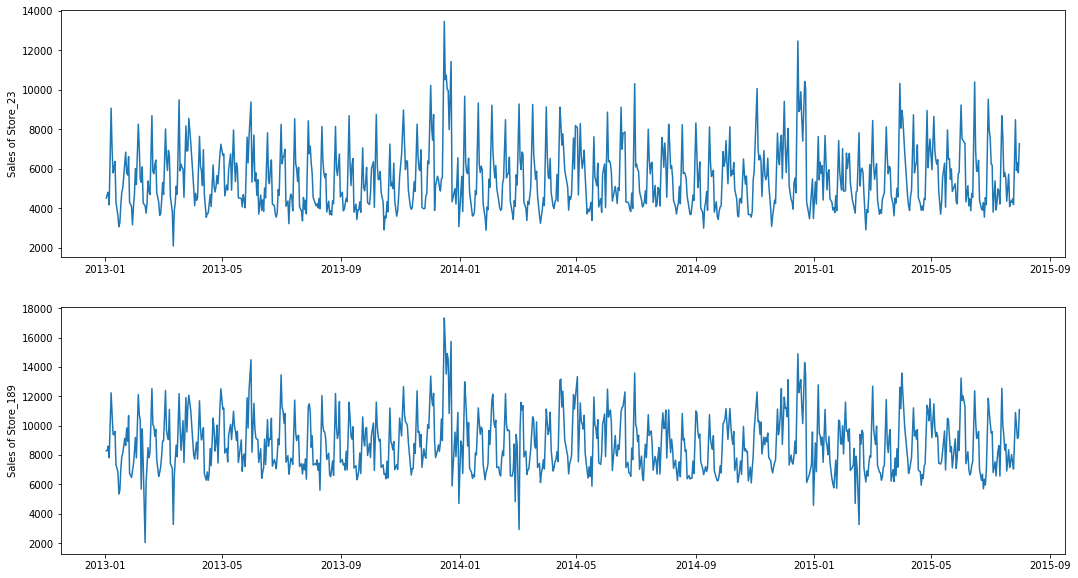

In [14]:
f = plt.figure(figsize=(18,10))
ax1 = f.add_subplot(211)
ax1.plot(store_23['Date'],store_23['Sales'])
ax1.set_ylabel('Sales of Store_23')


ax2 = f.add_subplot(212)
ax2.plot(store_189['Date'],store_189['Sales'])
ax2.set_ylabel('Sales of Store_189')

简览随机两个store的销售趋势，在2013年-2015年的三年间的波动趋势基本保持一致，而且明显在12月圣诞节附近有较大的增加，推测销售与节假日有较大关系。

ECDF: empirical cumulative distribution function

In [15]:
from statsmodels.distributions.empirical_distribution import ECDF

In [16]:
cdf=ECDF(df_train['Sales'])

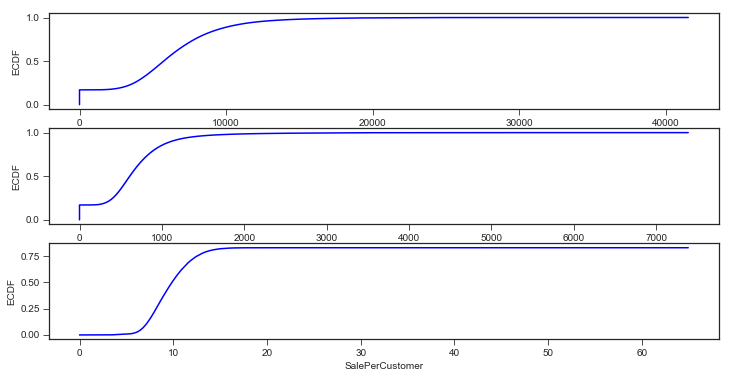

In [17]:
#sns.set(style='ticks')
sns.set_style('ticks')
plt.figure(figsize=(12,6))

plt.subplot(311)
cdf=ECDF(df_train['Sales'])
plt.plot(cdf.x,cdf.y,label = 'statsmodels',color='b')
plt.xlabel('Sales')
plt.ylabel('ECDF');

plt.subplot(312)
cdf=ECDF(df_train['Customers'])
plt.plot(cdf.x,cdf.y,label='statsmodels',color='b')
plt.xlabel('Customers')
plt.ylabel('ECDF');

plt.subplot(313)
cdf=ECDF(df_train['SalePerCustomer'])
plt.plot(cdf.x,cdf.y,label='statsmodels',color='b')
plt.xlabel('SalePerCustomer')
plt.ylabel('ECDF');

In [18]:
df_train[df_train['Sales']==0].count()[0]/df_train.count()[0]

0.16994639253093513

有17%数据是药店无客户无收入的状态，进一步确认这些是否均为不开业导致。

In [19]:
df_train[df_train['Open']==0].count()[0]/df_train.count()[0]

0.16989330609540418

药店不开业占数据占比为16.99%

In [20]:
df_train[(df_train['Open']==1) & (df_train['Sales']==0)].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,SalePerCustomer,WeekofYear
86825,971,5,2015-05-15,0,0,1,0,0,1,2015,5,15,NaN,20
142278,674,4,2015-03-26,0,0,1,0,0,0,2015,3,26,NaN,13
196938,699,4,2015-02-05,0,0,1,1,0,0,2015,2,5,NaN,6
322053,708,3,2014-10-01,0,0,1,1,0,0,2014,10,1,NaN,40
330176,357,1,2014-09-22,0,0,1,0,0,0,2014,9,22,NaN,39


- 合并探索数据集**store.csv**

**Short description:** 

- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [21]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [22]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [23]:
train_df=pd.merge(df_train,store,on='Store',how='left')

In [24]:
train_df.groupby('StoreType')['Sales','Customers'].sum()

,Sales,Customers
StoreType,,
a,3165334859,363541434
b,159231395,31465621
c,783221426,92129705
d,1765392943,156904995


In [25]:
train_df.groupby('StoreType')['SalePerCustomer'].mean()

StoreType
a     8.846277
b     5.133097
c     8.626227
d    11.277862
Name: SalePerCustomer, dtype: float64

In [26]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,...,WeekofYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,31,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,31,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


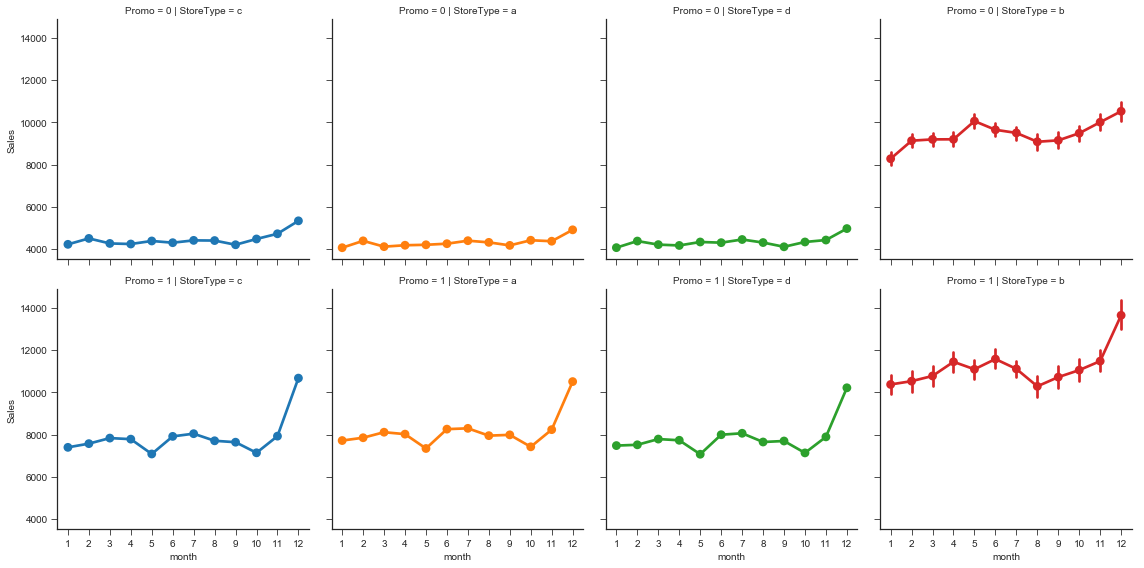

In [27]:
#sns.set(style="ticks")
sns.factorplot(x="month", y="Sales", data=train_df,
              col ='StoreType',
              row='Promo',
              hue='StoreType'
              );

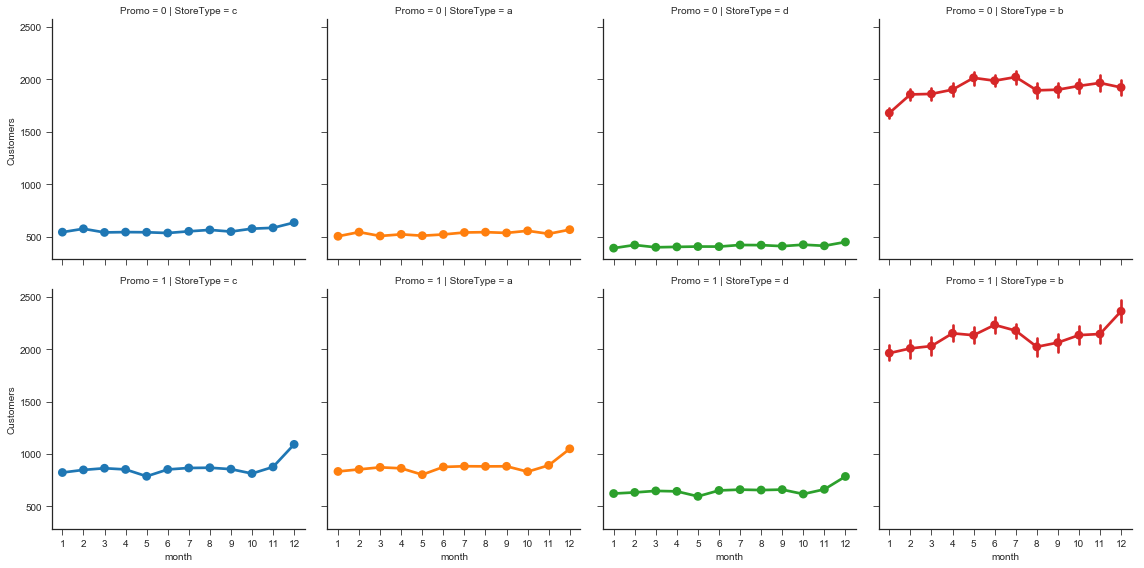

In [28]:
sns.factorplot(x="month", y="Customers", data=train_df,
              col ='StoreType',
              row='Promo',
              hue='StoreType'
              );

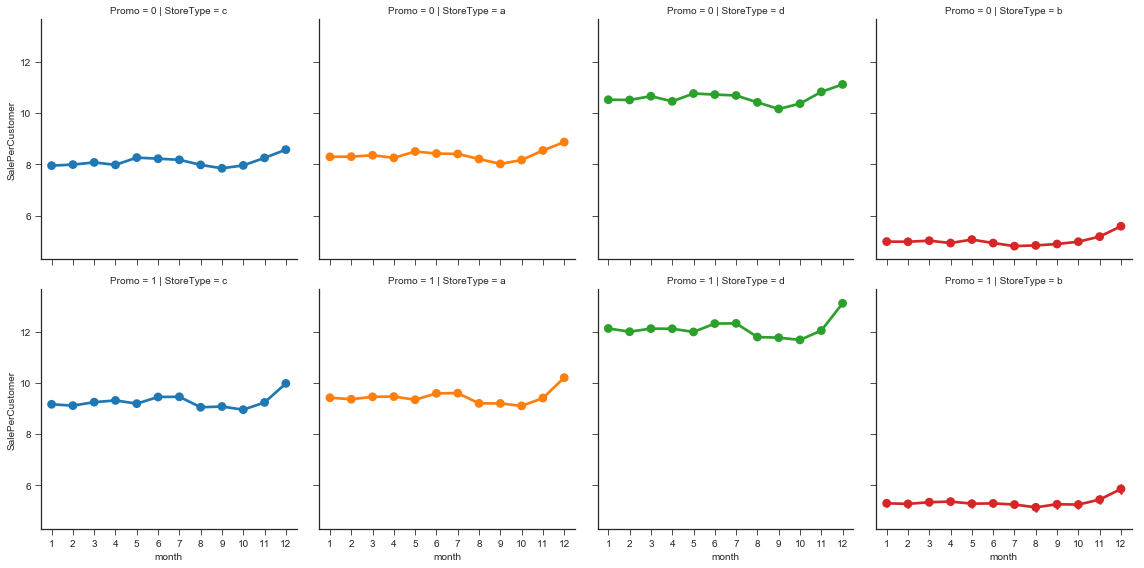

In [29]:
sns.factorplot(x="month", y="SalePerCustomer", data=train_df,
              col ='StoreType',
              row='Promo',
              hue='StoreType'
              );

基本销售趋势均保持一直，但是是否有促销以及药店类型对实际销售规模有较大的影响。当促销存在时，整体客户数以及销售额较平时有较大的增加；同时，对于类型为b的药店，销售额和客户量都明显高于其他类型的药店，但实际上每个客户的销售支出相对于其他药店而言，更小，推测b类型的药店主打的是小品类的商品。

### 处理数据集

1. 当前日期与竞争对手开业时间的时间差；
2. 当前日期与Promo2进行的时间差；
3. 当前的月份是否是促销月份；
4. 用0填充缺失值；
5. 将分类变量转换成数字变量；
6. 只用open = 1 且 sales > 0的train数据集作为训练数据集。

In [30]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
def data_EDA(data):
    data[['year','month','day']]=data.Date.str.split('-',expand=True).apply(pd.to_numeric)
    data['WeekofYear']=pd.to_datetime(data['Date']).dt.weekofyear
    
    data['CompetitionOpen']=12*(data.year-data.CompetitionOpenSinceYear)+(data.month-data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
    data['Promo2Open']=12*(data.year-data.Promo2SinceYear)+(data.WeekofYear-data.Promo2SinceWeek)/4.0
    data['Promo2Open'] = data['Promo2Open'].apply(lambda x: x if x > 0 else 0)
    
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    trans={'0':0,'a':1,'b':2,'c':3,'d':4}
    
    data['monthStr'] = data.month.map(month2str)

    #data['StoreType']=data.StoreType.map(trans)
    #data['Assortment']=data.Assortment.map(trans)
    #data['StateHoliday']=data.StateHoliday.map(trans)
    data = data.join(pd.get_dummies(data[['Assortment','StoreType','StateHoliday']]))
    
    data.fillna(0, inplace=True)
    data.loc[data.PromoInterval==0,'PromoInterval']=''
    data['IsPromoMonth']=0
    for item in data.PromoInterval.unique():
        if item !='':
            for month in item.split(','):
                data.loc[(data.monthStr == month)&(data.PromoInterval == item),'IsPromoMonth' ]=1
    return data

In [32]:
df_train = pd.read_csv('train.csv',parse_dates = True, low_memory = False)
df_test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv',low_memory = False)

# fill missing values in test with 1
df_test.fillna(value = 1, inplace = True)

train = pd.merge(df_train,store,on='Store',how='left')
test = pd.merge(df_test,store,on='Store',how='left')

In [33]:
valid_rate=0.012
valid_num = int(valid_rate * train.count()[0])
X_valid = train[:valid_num]
X_train = train[valid_num:]

In [35]:
train = train[(train.Open==1) & (train.Sales > 0)].sort_values(['Date'],ascending=False)
test = test.sort_values(['Date'],ascending=False)
train = data_EDA(train)
test = data_EDA(test)

In [38]:
#train = train[(train.Open==1) & (train.Sales > 0)]
#train = data_EDA(train)
#test = data_EDA(test)

### 建立预测模型

In [39]:
#from sklearn.model_selection import train_test_split

In [37]:
import xgboost as xgb

In [38]:
features=['Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'year', 'month', 'day',
       'WeekofYear', 'CompetitionOpen', 'Promo2Open', 'IsPromoMonth',
         'Assortment_a','Assortment_b','Assortment_c'
          ,'StoreType_a','StoreType_b','StoreType_c','StoreType_d'
          ,'StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c']  

In [40]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.04,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 13
          }
num_boost_round = 2500

In [41]:
valid_rate=0.012
valid_num = int(valid_rate * train.count()[0])
X_valid = train[:valid_num]
X_train = train[valid_num:]

In [42]:
#X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
y_total = np.log1p(train.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)
dtrain_total = xgb.DMatrix(train[features],y_total)

In [43]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [44]:
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [45]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

In [46]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:7.9381	eval-rmse:7.98486	train-rmspe:0.999777	eval-rmspe:0.999788
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.62132	eval-rmse:7.66858	train-rmspe:0.999631	eval-rmspe:0.999649
[2]	train-rmse:7.31711	eval-rmse:7.36234	train-rmspe:0.99944	eval-rmspe:0.999466
[3]	train-rmse:7.02509	eval-rmse:7.06952	train-rmspe:0.999193	eval-rmspe:0.999231
[4]	train-rmse:6.74472	eval-rmse:6.7878	train-rmspe:0.99888	eval-rmspe:0.998931
[5]	train-rmse:6.4756	eval-rmse:6.51712	train-rmspe:0.998484	eval-rmspe:0.998552
[6]	train-rmse:6.21726	eval-rmse:6.25631	train-rmspe:0.997991	eval-rmspe:0.998076
[7]	train-rmse:5.96929	eval-rmse:6.00592	train-rmspe:0.997383	eval-rmspe:0.997487
[8]	train-rmse:5.73127	eval-rmse:5.76572	train-rmspe:0.996638	eval-rmspe:0.996766
[9]	train-rmse:5.50282	eval-rmse:5.53608	train-rmspe:0.995738	eval-rmspe:0.995895
[10]	train-rmse:5.28354	eval-rmse:5.315

[97]	train-rmse:0.28101	eval-rmse:0.278614	train-rmspe:0.276465	eval-rmspe:0.246973
[98]	train-rmse:0.277539	eval-rmse:0.275467	train-rmspe:0.275507	eval-rmspe:0.245673
[99]	train-rmse:0.273696	eval-rmse:0.271549	train-rmspe:0.274089	eval-rmspe:0.24359
[100]	train-rmse:0.269916	eval-rmse:0.267865	train-rmspe:0.272592	eval-rmspe:0.241763
[101]	train-rmse:0.266872	eval-rmse:0.264687	train-rmspe:0.27166	eval-rmspe:0.240509
[102]	train-rmse:0.262707	eval-rmse:0.260565	train-rmspe:0.26989	eval-rmspe:0.238055
[103]	train-rmse:0.260007	eval-rmse:0.257966	train-rmspe:0.269245	eval-rmspe:0.237079
[104]	train-rmse:0.257706	eval-rmse:0.255693	train-rmspe:0.268876	eval-rmspe:0.236399
[105]	train-rmse:0.254282	eval-rmse:0.25244	train-rmspe:0.26754	eval-rmspe:0.23456
[106]	train-rmse:0.251587	eval-rmse:0.249748	train-rmspe:0.266398	eval-rmspe:0.233265
[107]	train-rmse:0.249408	eval-rmse:0.247523	train-rmspe:0.265622	eval-rmspe:0.232409
[108]	train-rmse:0.247197	eval-rmse:0.245394	train-rmspe:0.26514

[193]	train-rmse:0.170702	eval-rmse:0.173943	train-rmspe:0.220289	eval-rmspe:0.18452
[194]	train-rmse:0.170095	eval-rmse:0.173438	train-rmspe:0.219762	eval-rmspe:0.184045
[195]	train-rmse:0.169746	eval-rmse:0.173145	train-rmspe:0.219468	eval-rmspe:0.18372
[196]	train-rmse:0.168961	eval-rmse:0.172522	train-rmspe:0.218721	eval-rmspe:0.183119
[197]	train-rmse:0.168501	eval-rmse:0.172057	train-rmspe:0.218373	eval-rmspe:0.182645
[198]	train-rmse:0.168214	eval-rmse:0.171729	train-rmspe:0.218131	eval-rmspe:0.18243
[199]	train-rmse:0.168063	eval-rmse:0.171633	train-rmspe:0.21802	eval-rmspe:0.182438
[200]	train-rmse:0.167682	eval-rmse:0.171292	train-rmspe:0.215948	eval-rmspe:0.182112
[201]	train-rmse:0.167352	eval-rmse:0.171013	train-rmspe:0.215667	eval-rmspe:0.181793
[202]	train-rmse:0.166908	eval-rmse:0.17068	train-rmspe:0.215356	eval-rmspe:0.181446
[203]	train-rmse:0.166654	eval-rmse:0.170484	train-rmspe:0.215164	eval-rmspe:0.181317
[204]	train-rmse:0.166055	eval-rmse:0.169995	train-rmspe:0.

[289]	train-rmse:0.137768	eval-rmse:0.145269	train-rmspe:0.185265	eval-rmspe:0.152866
[290]	train-rmse:0.137358	eval-rmse:0.144902	train-rmspe:0.184955	eval-rmspe:0.152478
[291]	train-rmse:0.137222	eval-rmse:0.14478	train-rmspe:0.184845	eval-rmspe:0.152346
[292]	train-rmse:0.137053	eval-rmse:0.144626	train-rmspe:0.184613	eval-rmspe:0.152187
[293]	train-rmse:0.136628	eval-rmse:0.144253	train-rmspe:0.183969	eval-rmspe:0.151768
[294]	train-rmse:0.136125	eval-rmse:0.143745	train-rmspe:0.183519	eval-rmspe:0.15123
[295]	train-rmse:0.136033	eval-rmse:0.143684	train-rmspe:0.181492	eval-rmspe:0.151162
[296]	train-rmse:0.135827	eval-rmse:0.143399	train-rmspe:0.181318	eval-rmspe:0.150823
[297]	train-rmse:0.135115	eval-rmse:0.142786	train-rmspe:0.180763	eval-rmspe:0.150149
[298]	train-rmse:0.134961	eval-rmse:0.142586	train-rmspe:0.180616	eval-rmspe:0.149954
[299]	train-rmse:0.134673	eval-rmse:0.142358	train-rmspe:0.180213	eval-rmspe:0.149696
[300]	train-rmse:0.134254	eval-rmse:0.142	train-rmspe:0.

[385]	train-rmse:0.117855	eval-rmse:0.128332	train-rmspe:0.155857	eval-rmspe:0.134061
[386]	train-rmse:0.117818	eval-rmse:0.128311	train-rmspe:0.155829	eval-rmspe:0.134037
[387]	train-rmse:0.117598	eval-rmse:0.128126	train-rmspe:0.155596	eval-rmspe:0.133855
[388]	train-rmse:0.117378	eval-rmse:0.127988	train-rmspe:0.155366	eval-rmspe:0.133698
[389]	train-rmse:0.117237	eval-rmse:0.12786	train-rmspe:0.155243	eval-rmspe:0.133554
[390]	train-rmse:0.117176	eval-rmse:0.12779	train-rmspe:0.155164	eval-rmspe:0.13345
[391]	train-rmse:0.117054	eval-rmse:0.127707	train-rmspe:0.155066	eval-rmspe:0.133345
[392]	train-rmse:0.116902	eval-rmse:0.127591	train-rmspe:0.154936	eval-rmspe:0.133197
[393]	train-rmse:0.116822	eval-rmse:0.1275	train-rmspe:0.154868	eval-rmspe:0.133095
[394]	train-rmse:0.116717	eval-rmse:0.127334	train-rmspe:0.154779	eval-rmspe:0.132933
[395]	train-rmse:0.11666	eval-rmse:0.127303	train-rmspe:0.154746	eval-rmspe:0.132903
[396]	train-rmse:0.116554	eval-rmse:0.127202	train-rmspe:0.1

[481]	train-rmse:0.107707	eval-rmse:0.120191	train-rmspe:0.140259	eval-rmspe:0.124553
[482]	train-rmse:0.107635	eval-rmse:0.12008	train-rmspe:0.14019	eval-rmspe:0.124409
[483]	train-rmse:0.107567	eval-rmse:0.120034	train-rmspe:0.140131	eval-rmspe:0.124351
[484]	train-rmse:0.10751	eval-rmse:0.119963	train-rmspe:0.140075	eval-rmspe:0.124245
[485]	train-rmse:0.107443	eval-rmse:0.119841	train-rmspe:0.140016	eval-rmspe:0.124133
[486]	train-rmse:0.107356	eval-rmse:0.119764	train-rmspe:0.139942	eval-rmspe:0.124053
[487]	train-rmse:0.107265	eval-rmse:0.119711	train-rmspe:0.139863	eval-rmspe:0.123982
[488]	train-rmse:0.107247	eval-rmse:0.119702	train-rmspe:0.139822	eval-rmspe:0.123972
[489]	train-rmse:0.107144	eval-rmse:0.119606	train-rmspe:0.139735	eval-rmspe:0.12386
[490]	train-rmse:0.107084	eval-rmse:0.119568	train-rmspe:0.139671	eval-rmspe:0.123815
[491]	train-rmse:0.10702	eval-rmse:0.119487	train-rmspe:0.13961	eval-rmspe:0.123688
[492]	train-rmse:0.106953	eval-rmse:0.119461	train-rmspe:0.1

[577]	train-rmse:0.101057	eval-rmse:0.114605	train-rmspe:0.133019	eval-rmspe:0.118371
[578]	train-rmse:0.101031	eval-rmse:0.114597	train-rmspe:0.133	eval-rmspe:0.118371
[579]	train-rmse:0.101002	eval-rmse:0.114575	train-rmspe:0.132976	eval-rmspe:0.118342
[580]	train-rmse:0.100928	eval-rmse:0.114518	train-rmspe:0.131098	eval-rmspe:0.118285
[581]	train-rmse:0.100871	eval-rmse:0.114493	train-rmspe:0.130277	eval-rmspe:0.118264
[582]	train-rmse:0.100769	eval-rmse:0.114397	train-rmspe:0.1302	eval-rmspe:0.11816
[583]	train-rmse:0.100726	eval-rmse:0.114374	train-rmspe:0.130157	eval-rmspe:0.118137
[584]	train-rmse:0.100692	eval-rmse:0.114338	train-rmspe:0.130121	eval-rmspe:0.118107
[585]	train-rmse:0.10064	eval-rmse:0.114298	train-rmspe:0.130072	eval-rmspe:0.118068
[586]	train-rmse:0.100562	eval-rmse:0.11427	train-rmspe:0.129988	eval-rmspe:0.118072
[587]	train-rmse:0.100519	eval-rmse:0.114221	train-rmspe:0.129955	eval-rmspe:0.118019
[588]	train-rmse:0.100487	eval-rmse:0.114141	train-rmspe:0.129

[673]	train-rmse:0.096176	eval-rmse:0.11088	train-rmspe:0.121249	eval-rmspe:0.114376
[674]	train-rmse:0.096141	eval-rmse:0.110862	train-rmspe:0.12122	eval-rmspe:0.114358
[675]	train-rmse:0.096109	eval-rmse:0.110852	train-rmspe:0.121183	eval-rmspe:0.114347
[676]	train-rmse:0.096048	eval-rmse:0.110827	train-rmspe:0.12112	eval-rmspe:0.114314
[677]	train-rmse:0.095979	eval-rmse:0.110789	train-rmspe:0.121056	eval-rmspe:0.114272
[678]	train-rmse:0.095924	eval-rmse:0.110764	train-rmspe:0.121003	eval-rmspe:0.114237
[679]	train-rmse:0.095882	eval-rmse:0.110749	train-rmspe:0.120951	eval-rmspe:0.114221
[680]	train-rmse:0.095802	eval-rmse:0.1107	train-rmspe:0.120877	eval-rmspe:0.114169
[681]	train-rmse:0.095781	eval-rmse:0.110686	train-rmspe:0.120856	eval-rmspe:0.114154
[682]	train-rmse:0.09575	eval-rmse:0.110672	train-rmspe:0.120811	eval-rmspe:0.114139
[683]	train-rmse:0.095715	eval-rmse:0.110629	train-rmspe:0.120783	eval-rmspe:0.114097
[684]	train-rmse:0.095675	eval-rmse:0.110595	train-rmspe:0.1

[769]	train-rmse:0.092259	eval-rmse:0.108412	train-rmspe:0.115646	eval-rmspe:0.111779
[770]	train-rmse:0.092208	eval-rmse:0.108404	train-rmspe:0.115582	eval-rmspe:0.111837
[771]	train-rmse:0.092173	eval-rmse:0.108398	train-rmspe:0.11555	eval-rmspe:0.111802
[772]	train-rmse:0.092145	eval-rmse:0.108383	train-rmspe:0.115522	eval-rmspe:0.111784
[773]	train-rmse:0.09209	eval-rmse:0.10835	train-rmspe:0.115471	eval-rmspe:0.111748
[774]	train-rmse:0.092076	eval-rmse:0.10834	train-rmspe:0.115452	eval-rmspe:0.111735
[775]	train-rmse:0.092035	eval-rmse:0.108314	train-rmspe:0.115414	eval-rmspe:0.111711
[776]	train-rmse:0.091998	eval-rmse:0.108325	train-rmspe:0.115383	eval-rmspe:0.111716
[777]	train-rmse:0.091965	eval-rmse:0.108318	train-rmspe:0.115354	eval-rmspe:0.111718
[778]	train-rmse:0.09193	eval-rmse:0.10831	train-rmspe:0.115282	eval-rmspe:0.111705
[779]	train-rmse:0.091899	eval-rmse:0.108297	train-rmspe:0.115242	eval-rmspe:0.111681
[780]	train-rmse:0.091846	eval-rmse:0.108264	train-rmspe:0.1

[865]	train-rmse:0.089036	eval-rmse:0.106848	train-rmspe:0.111079	eval-rmspe:0.110137
[866]	train-rmse:0.089006	eval-rmse:0.106825	train-rmspe:0.111025	eval-rmspe:0.11011
[867]	train-rmse:0.088974	eval-rmse:0.106801	train-rmspe:0.110998	eval-rmspe:0.110085
[868]	train-rmse:0.088941	eval-rmse:0.106785	train-rmspe:0.110957	eval-rmspe:0.110075
[869]	train-rmse:0.088905	eval-rmse:0.106757	train-rmspe:0.110925	eval-rmspe:0.110046
[870]	train-rmse:0.088861	eval-rmse:0.106746	train-rmspe:0.110859	eval-rmspe:0.110031
[871]	train-rmse:0.088841	eval-rmse:0.106739	train-rmspe:0.110829	eval-rmspe:0.110024
[872]	train-rmse:0.088809	eval-rmse:0.10672	train-rmspe:0.110765	eval-rmspe:0.110002
[873]	train-rmse:0.088779	eval-rmse:0.106686	train-rmspe:0.110737	eval-rmspe:0.109966
[874]	train-rmse:0.088748	eval-rmse:0.106671	train-rmspe:0.110707	eval-rmspe:0.10995
[875]	train-rmse:0.088709	eval-rmse:0.106661	train-rmspe:0.110662	eval-rmspe:0.109936
[876]	train-rmse:0.088681	eval-rmse:0.106641	train-rmspe:

[961]	train-rmse:0.086573	eval-rmse:0.105524	train-rmspe:0.107188	eval-rmspe:0.108781
[962]	train-rmse:0.086553	eval-rmse:0.105506	train-rmspe:0.107166	eval-rmspe:0.108763
[963]	train-rmse:0.086522	eval-rmse:0.105493	train-rmspe:0.106578	eval-rmspe:0.108751
[964]	train-rmse:0.086502	eval-rmse:0.105477	train-rmspe:0.106559	eval-rmspe:0.108734
[965]	train-rmse:0.086486	eval-rmse:0.105463	train-rmspe:0.106544	eval-rmspe:0.108717
[966]	train-rmse:0.086474	eval-rmse:0.10547	train-rmspe:0.106534	eval-rmspe:0.108718
[967]	train-rmse:0.086442	eval-rmse:0.105444	train-rmspe:0.106488	eval-rmspe:0.108689
[968]	train-rmse:0.086421	eval-rmse:0.105424	train-rmspe:0.106471	eval-rmspe:0.108665
[969]	train-rmse:0.086408	eval-rmse:0.105416	train-rmspe:0.10646	eval-rmspe:0.108656
[970]	train-rmse:0.086389	eval-rmse:0.105408	train-rmspe:0.106441	eval-rmspe:0.108647
[971]	train-rmse:0.086371	eval-rmse:0.105392	train-rmspe:0.106422	eval-rmspe:0.10863
[972]	train-rmse:0.086352	eval-rmse:0.105377	train-rmspe:

[1057]	train-rmse:0.084301	eval-rmse:0.10425	train-rmspe:0.103739	eval-rmspe:0.107444
[1058]	train-rmse:0.084288	eval-rmse:0.104243	train-rmspe:0.103714	eval-rmspe:0.107436
[1059]	train-rmse:0.084265	eval-rmse:0.104221	train-rmspe:0.103645	eval-rmspe:0.107411
[1060]	train-rmse:0.084243	eval-rmse:0.104213	train-rmspe:0.103623	eval-rmspe:0.107399
[1061]	train-rmse:0.08421	eval-rmse:0.104189	train-rmspe:0.103592	eval-rmspe:0.107383
[1062]	train-rmse:0.084197	eval-rmse:0.10418	train-rmspe:0.103574	eval-rmspe:0.107375
[1063]	train-rmse:0.084173	eval-rmse:0.104136	train-rmspe:0.103511	eval-rmspe:0.107329
[1064]	train-rmse:0.084152	eval-rmse:0.104132	train-rmspe:0.103494	eval-rmspe:0.107325
[1065]	train-rmse:0.08413	eval-rmse:0.104134	train-rmspe:0.103461	eval-rmspe:0.107319
[1066]	train-rmse:0.08411	eval-rmse:0.104114	train-rmspe:0.103445	eval-rmspe:0.107306
[1067]	train-rmse:0.084094	eval-rmse:0.104102	train-rmspe:0.103426	eval-rmspe:0.107295
[1068]	train-rmse:0.084069	eval-rmse:0.10407	tra

[1152]	train-rmse:0.082399	eval-rmse:0.103304	train-rmspe:0.100118	eval-rmspe:0.106424
[1153]	train-rmse:0.082383	eval-rmse:0.103298	train-rmspe:0.100101	eval-rmspe:0.106415
[1154]	train-rmse:0.082354	eval-rmse:0.103293	train-rmspe:0.100063	eval-rmspe:0.106407
[1155]	train-rmse:0.082341	eval-rmse:0.103286	train-rmspe:0.100002	eval-rmspe:0.106399
[1156]	train-rmse:0.082327	eval-rmse:0.103285	train-rmspe:0.099989	eval-rmspe:0.106396
[1157]	train-rmse:0.082304	eval-rmse:0.103276	train-rmspe:0.099966	eval-rmspe:0.106386
[1158]	train-rmse:0.082285	eval-rmse:0.103269	train-rmspe:0.099947	eval-rmspe:0.106379
[1159]	train-rmse:0.082264	eval-rmse:0.103257	train-rmspe:0.099928	eval-rmspe:0.106367
[1160]	train-rmse:0.082252	eval-rmse:0.103252	train-rmspe:0.099911	eval-rmspe:0.106361
[1161]	train-rmse:0.08223	eval-rmse:0.103241	train-rmspe:0.099888	eval-rmspe:0.106349
[1162]	train-rmse:0.082214	eval-rmse:0.103253	train-rmspe:0.099871	eval-rmspe:0.106354
[1163]	train-rmse:0.082198	eval-rmse:0.10324

[1247]	train-rmse:0.080784	eval-rmse:0.102606	train-rmspe:0.095696	eval-rmspe:0.10569
[1248]	train-rmse:0.080768	eval-rmse:0.102599	train-rmspe:0.095678	eval-rmspe:0.105682
[1249]	train-rmse:0.080756	eval-rmse:0.102596	train-rmspe:0.095666	eval-rmspe:0.105678
[1250]	train-rmse:0.080738	eval-rmse:0.102591	train-rmspe:0.095644	eval-rmspe:0.105677
[1251]	train-rmse:0.080726	eval-rmse:0.102586	train-rmspe:0.09563	eval-rmspe:0.105669
[1252]	train-rmse:0.080709	eval-rmse:0.102589	train-rmspe:0.095611	eval-rmspe:0.105676
[1253]	train-rmse:0.080692	eval-rmse:0.102586	train-rmspe:0.095589	eval-rmspe:0.105674
[1254]	train-rmse:0.080683	eval-rmse:0.102593	train-rmspe:0.095579	eval-rmspe:0.105689
[1255]	train-rmse:0.080668	eval-rmse:0.102592	train-rmspe:0.095558	eval-rmspe:0.105688
[1256]	train-rmse:0.080645	eval-rmse:0.10256	train-rmspe:0.095532	eval-rmspe:0.105657
[1257]	train-rmse:0.080625	eval-rmse:0.102558	train-rmspe:0.095513	eval-rmspe:0.105663
[1258]	train-rmse:0.080613	eval-rmse:0.102552	

[1342]	train-rmse:0.079229	eval-rmse:0.101993	train-rmspe:0.093807	eval-rmspe:0.105089
[1343]	train-rmse:0.079213	eval-rmse:0.101985	train-rmspe:0.093793	eval-rmspe:0.105081
[1344]	train-rmse:0.079204	eval-rmse:0.101977	train-rmspe:0.093782	eval-rmspe:0.105073
[1345]	train-rmse:0.079187	eval-rmse:0.101969	train-rmspe:0.093769	eval-rmspe:0.105062
[1346]	train-rmse:0.079175	eval-rmse:0.101966	train-rmspe:0.093754	eval-rmspe:0.10506
[1347]	train-rmse:0.079164	eval-rmse:0.101951	train-rmspe:0.09374	eval-rmspe:0.105047
[1348]	train-rmse:0.079147	eval-rmse:0.101948	train-rmspe:0.093705	eval-rmspe:0.105044
[1349]	train-rmse:0.079137	eval-rmse:0.101943	train-rmspe:0.093693	eval-rmspe:0.105038
[1350]	train-rmse:0.079111	eval-rmse:0.101932	train-rmspe:0.093668	eval-rmspe:0.105028
[1351]	train-rmse:0.079098	eval-rmse:0.101927	train-rmspe:0.093653	eval-rmspe:0.105004
[1352]	train-rmse:0.079087	eval-rmse:0.10192	train-rmspe:0.093642	eval-rmspe:0.105001
[1353]	train-rmse:0.07908	eval-rmse:0.101917	t

[1437]	train-rmse:0.077928	eval-rmse:0.101483	train-rmspe:0.092006	eval-rmspe:0.104588
[1438]	train-rmse:0.077914	eval-rmse:0.101474	train-rmspe:0.091994	eval-rmspe:0.104581
[1439]	train-rmse:0.077888	eval-rmse:0.101465	train-rmspe:0.091968	eval-rmspe:0.104569
[1440]	train-rmse:0.077855	eval-rmse:0.101449	train-rmspe:0.091926	eval-rmspe:0.104548
[1441]	train-rmse:0.077842	eval-rmse:0.101447	train-rmspe:0.091912	eval-rmspe:0.104544
[1442]	train-rmse:0.077824	eval-rmse:0.101453	train-rmspe:0.091887	eval-rmspe:0.104546
[1443]	train-rmse:0.07781	eval-rmse:0.10145	train-rmspe:0.091871	eval-rmspe:0.104542
[1444]	train-rmse:0.077799	eval-rmse:0.101442	train-rmspe:0.091854	eval-rmspe:0.104535
[1445]	train-rmse:0.077791	eval-rmse:0.101437	train-rmspe:0.09186	eval-rmspe:0.104531
[1446]	train-rmse:0.077771	eval-rmse:0.101433	train-rmspe:0.091841	eval-rmspe:0.104527
[1447]	train-rmse:0.077754	eval-rmse:0.101421	train-rmspe:0.091823	eval-rmspe:0.104517
[1448]	train-rmse:0.077752	eval-rmse:0.10142	t

[1532]	train-rmse:0.076571	eval-rmse:0.100978	train-rmspe:0.088546	eval-rmspe:0.104051
[1533]	train-rmse:0.076556	eval-rmse:0.100963	train-rmspe:0.088527	eval-rmspe:0.104039
[1534]	train-rmse:0.076531	eval-rmse:0.100947	train-rmspe:0.088489	eval-rmspe:0.104022
[1535]	train-rmse:0.076516	eval-rmse:0.100945	train-rmspe:0.088461	eval-rmspe:0.104022
[1536]	train-rmse:0.076506	eval-rmse:0.100941	train-rmspe:0.088452	eval-rmspe:0.104018
[1537]	train-rmse:0.076494	eval-rmse:0.100925	train-rmspe:0.088434	eval-rmspe:0.104004
[1538]	train-rmse:0.076476	eval-rmse:0.10092	train-rmspe:0.088417	eval-rmspe:0.104006
[1539]	train-rmse:0.07646	eval-rmse:0.100911	train-rmspe:0.088392	eval-rmspe:0.103995
[1540]	train-rmse:0.076448	eval-rmse:0.100914	train-rmspe:0.088404	eval-rmspe:0.103993
[1541]	train-rmse:0.076437	eval-rmse:0.10091	train-rmspe:0.088394	eval-rmspe:0.103991
[1542]	train-rmse:0.076427	eval-rmse:0.10091	train-rmspe:0.088372	eval-rmspe:0.103989
[1543]	train-rmse:0.076413	eval-rmse:0.100907	t

[1627]	train-rmse:0.075294	eval-rmse:0.100584	train-rmspe:0.086233	eval-rmspe:0.103678
[1628]	train-rmse:0.075278	eval-rmse:0.100579	train-rmspe:0.086214	eval-rmspe:0.103672
[1629]	train-rmse:0.075267	eval-rmse:0.100576	train-rmspe:0.086202	eval-rmspe:0.103666
[1630]	train-rmse:0.075263	eval-rmse:0.100584	train-rmspe:0.086199	eval-rmspe:0.103672
[1631]	train-rmse:0.075257	eval-rmse:0.100589	train-rmspe:0.086192	eval-rmspe:0.103678
[1632]	train-rmse:0.075248	eval-rmse:0.10059	train-rmspe:0.086119	eval-rmspe:0.103679
[1633]	train-rmse:0.075234	eval-rmse:0.10061	train-rmspe:0.086102	eval-rmspe:0.103668
[1634]	train-rmse:0.075219	eval-rmse:0.100588	train-rmspe:0.086088	eval-rmspe:0.103648
[1635]	train-rmse:0.075211	eval-rmse:0.100598	train-rmspe:0.08608	eval-rmspe:0.103657
[1636]	train-rmse:0.075205	eval-rmse:0.100597	train-rmspe:0.086074	eval-rmspe:0.103657
[1637]	train-rmse:0.075196	eval-rmse:0.100592	train-rmspe:0.086064	eval-rmspe:0.103653
[1638]	train-rmse:0.075176	eval-rmse:0.100584	

[1722]	train-rmse:0.074172	eval-rmse:0.100322	train-rmspe:0.083587	eval-rmspe:0.103345
[1723]	train-rmse:0.074156	eval-rmse:0.100326	train-rmspe:0.083567	eval-rmspe:0.103353
[1724]	train-rmse:0.074139	eval-rmse:0.100322	train-rmspe:0.083548	eval-rmspe:0.103351
[1725]	train-rmse:0.074126	eval-rmse:0.100321	train-rmspe:0.083536	eval-rmspe:0.10335
[1726]	train-rmse:0.074111	eval-rmse:0.100317	train-rmspe:0.083522	eval-rmspe:0.103346
[1727]	train-rmse:0.074101	eval-rmse:0.100313	train-rmspe:0.083326	eval-rmspe:0.10334
[1728]	train-rmse:0.074094	eval-rmse:0.100309	train-rmspe:0.083319	eval-rmspe:0.103336
[1729]	train-rmse:0.074081	eval-rmse:0.100299	train-rmspe:0.083307	eval-rmspe:0.103326
[1730]	train-rmse:0.074067	eval-rmse:0.100297	train-rmspe:0.083286	eval-rmspe:0.103324
[1731]	train-rmse:0.074052	eval-rmse:0.100289	train-rmspe:0.083266	eval-rmspe:0.103309
[1732]	train-rmse:0.074043	eval-rmse:0.100277	train-rmspe:0.083256	eval-rmspe:0.103296
[1733]	train-rmse:0.074025	eval-rmse:0.100268

[1817]	train-rmse:0.073099	eval-rmse:0.100033	train-rmspe:0.081508	eval-rmspe:0.103031
[1818]	train-rmse:0.07309	eval-rmse:0.100038	train-rmspe:0.081498	eval-rmspe:0.103037
[1819]	train-rmse:0.073082	eval-rmse:0.100038	train-rmspe:0.081488	eval-rmspe:0.103037
[1820]	train-rmse:0.073074	eval-rmse:0.100036	train-rmspe:0.081479	eval-rmspe:0.103035
[1821]	train-rmse:0.073058	eval-rmse:0.100031	train-rmspe:0.081458	eval-rmspe:0.10303
[1822]	train-rmse:0.073048	eval-rmse:0.10003	train-rmspe:0.081446	eval-rmspe:0.103031
[1823]	train-rmse:0.073037	eval-rmse:0.100019	train-rmspe:0.081422	eval-rmspe:0.103021
[1824]	train-rmse:0.073027	eval-rmse:0.10002	train-rmspe:0.081412	eval-rmspe:0.103022
[1825]	train-rmse:0.073014	eval-rmse:0.100029	train-rmspe:0.0814	eval-rmspe:0.103027
[1826]	train-rmse:0.073002	eval-rmse:0.100032	train-rmspe:0.081383	eval-rmspe:0.103032
[1827]	train-rmse:0.072992	eval-rmse:0.100031	train-rmspe:0.081371	eval-rmspe:0.103032
[1828]	train-rmse:0.072981	eval-rmse:0.100023	tra

[1912]	train-rmse:0.072075	eval-rmse:0.099831	train-rmspe:0.079796	eval-rmspe:0.10283
[1913]	train-rmse:0.072064	eval-rmse:0.099833	train-rmspe:0.0797	eval-rmspe:0.10283
[1914]	train-rmse:0.072051	eval-rmse:0.099828	train-rmspe:0.079686	eval-rmspe:0.102826
[1915]	train-rmse:0.072042	eval-rmse:0.099825	train-rmspe:0.079677	eval-rmspe:0.102824
[1916]	train-rmse:0.072032	eval-rmse:0.099821	train-rmspe:0.079656	eval-rmspe:0.102822
[1917]	train-rmse:0.072021	eval-rmse:0.099831	train-rmspe:0.079644	eval-rmspe:0.102816
[1918]	train-rmse:0.072009	eval-rmse:0.099829	train-rmspe:0.079631	eval-rmspe:0.102815
[1919]	train-rmse:0.072	eval-rmse:0.099829	train-rmspe:0.079622	eval-rmspe:0.102814
[1920]	train-rmse:0.071991	eval-rmse:0.099829	train-rmspe:0.079613	eval-rmspe:0.102817
[1921]	train-rmse:0.071986	eval-rmse:0.099829	train-rmspe:0.079609	eval-rmspe:0.102817
[1922]	train-rmse:0.071975	eval-rmse:0.099821	train-rmspe:0.079595	eval-rmspe:0.102811
[1923]	train-rmse:0.071966	eval-rmse:0.099816	trai

[2007]	train-rmse:0.071181	eval-rmse:0.099724	train-rmspe:0.078653	eval-rmspe:0.102672
[2008]	train-rmse:0.071171	eval-rmse:0.099719	train-rmspe:0.078641	eval-rmspe:0.102667
[2009]	train-rmse:0.071161	eval-rmse:0.099716	train-rmspe:0.078625	eval-rmspe:0.102666
[2010]	train-rmse:0.071156	eval-rmse:0.099714	train-rmspe:0.078619	eval-rmspe:0.102664
[2011]	train-rmse:0.071146	eval-rmse:0.099719	train-rmspe:0.078609	eval-rmspe:0.102667
[2012]	train-rmse:0.071134	eval-rmse:0.099717	train-rmspe:0.078593	eval-rmspe:0.102661
[2013]	train-rmse:0.071118	eval-rmse:0.099708	train-rmspe:0.078569	eval-rmspe:0.102653
[2014]	train-rmse:0.071107	eval-rmse:0.09971	train-rmspe:0.078551	eval-rmspe:0.102659
[2015]	train-rmse:0.0711	eval-rmse:0.099707	train-rmspe:0.078541	eval-rmspe:0.102657
[2016]	train-rmse:0.07109	eval-rmse:0.099714	train-rmspe:0.078527	eval-rmspe:0.102665
[2017]	train-rmse:0.071084	eval-rmse:0.099714	train-rmspe:0.078519	eval-rmspe:0.102664
[2018]	train-rmse:0.071074	eval-rmse:0.099719	t

[2102]	train-rmse:0.070262	eval-rmse:0.099557	train-rmspe:0.077439	eval-rmspe:0.102465
[2103]	train-rmse:0.070253	eval-rmse:0.09956	train-rmspe:0.077423	eval-rmspe:0.102467
[2104]	train-rmse:0.070245	eval-rmse:0.099558	train-rmspe:0.077413	eval-rmspe:0.102465
[2105]	train-rmse:0.070239	eval-rmse:0.099555	train-rmspe:0.077407	eval-rmspe:0.102458
[2106]	train-rmse:0.07023	eval-rmse:0.099555	train-rmspe:0.077397	eval-rmspe:0.102458
[2107]	train-rmse:0.070219	eval-rmse:0.099552	train-rmspe:0.077386	eval-rmspe:0.102452
[2108]	train-rmse:0.070214	eval-rmse:0.099558	train-rmspe:0.077379	eval-rmspe:0.102456
[2109]	train-rmse:0.070208	eval-rmse:0.099559	train-rmspe:0.077372	eval-rmspe:0.102458
[2110]	train-rmse:0.0702	eval-rmse:0.099558	train-rmspe:0.077363	eval-rmspe:0.102457
[2111]	train-rmse:0.07019	eval-rmse:0.099561	train-rmspe:0.077352	eval-rmspe:0.10246
[2112]	train-rmse:0.070182	eval-rmse:0.099559	train-rmspe:0.077343	eval-rmspe:0.102459
[2113]	train-rmse:0.070174	eval-rmse:0.099559	tra

[2197]	train-rmse:0.069414	eval-rmse:0.099499	train-rmspe:0.076078	eval-rmspe:0.102402
[2198]	train-rmse:0.069409	eval-rmse:0.099499	train-rmspe:0.076073	eval-rmspe:0.102401
[2199]	train-rmse:0.069405	eval-rmse:0.099499	train-rmspe:0.076067	eval-rmspe:0.102402
[2200]	train-rmse:0.0694	eval-rmse:0.099499	train-rmspe:0.076061	eval-rmspe:0.102401
[2201]	train-rmse:0.06939	eval-rmse:0.099492	train-rmspe:0.076048	eval-rmspe:0.102394
[2202]	train-rmse:0.069378	eval-rmse:0.099501	train-rmspe:0.076033	eval-rmspe:0.102399
[2203]	train-rmse:0.069369	eval-rmse:0.0995	train-rmspe:0.076019	eval-rmspe:0.102397
[2204]	train-rmse:0.069359	eval-rmse:0.099499	train-rmspe:0.076004	eval-rmspe:0.102394
[2205]	train-rmse:0.069347	eval-rmse:0.099498	train-rmspe:0.075985	eval-rmspe:0.102391
[2206]	train-rmse:0.06934	eval-rmse:0.099498	train-rmspe:0.07597	eval-rmspe:0.102391
[2207]	train-rmse:0.069334	eval-rmse:0.099498	train-rmspe:0.075926	eval-rmspe:0.102391
[2208]	train-rmse:0.069324	eval-rmse:0.099497	trai

[2292]	train-rmse:0.068579	eval-rmse:0.099339	train-rmspe:0.074952	eval-rmspe:0.102209
[2293]	train-rmse:0.068575	eval-rmse:0.099337	train-rmspe:0.074946	eval-rmspe:0.102206
[2294]	train-rmse:0.068565	eval-rmse:0.099346	train-rmspe:0.074935	eval-rmspe:0.102215
[2295]	train-rmse:0.068552	eval-rmse:0.099344	train-rmspe:0.074912	eval-rmspe:0.102214
[2296]	train-rmse:0.068542	eval-rmse:0.099368	train-rmspe:0.074899	eval-rmspe:0.102258
[2297]	train-rmse:0.06853	eval-rmse:0.099366	train-rmspe:0.074885	eval-rmspe:0.102255
[2298]	train-rmse:0.068521	eval-rmse:0.099359	train-rmspe:0.074868	eval-rmspe:0.102249
[2299]	train-rmse:0.068515	eval-rmse:0.099374	train-rmspe:0.07486	eval-rmspe:0.102275
[2300]	train-rmse:0.068503	eval-rmse:0.099377	train-rmspe:0.074848	eval-rmspe:0.102276
[2301]	train-rmse:0.0685	eval-rmse:0.099375	train-rmspe:0.074847	eval-rmspe:0.102275
[2302]	train-rmse:0.06849	eval-rmse:0.09938	train-rmspe:0.074834	eval-rmspe:0.102277
[2303]	train-rmse:0.068479	eval-rmse:0.099385	tra

[2387]	train-rmse:0.067806	eval-rmse:0.099305	train-rmspe:0.073769	eval-rmspe:0.102166
[2388]	train-rmse:0.067798	eval-rmse:0.099308	train-rmspe:0.073748	eval-rmspe:0.102169
[2389]	train-rmse:0.067786	eval-rmse:0.099305	train-rmspe:0.073733	eval-rmspe:0.102167
[2390]	train-rmse:0.067782	eval-rmse:0.099304	train-rmspe:0.073728	eval-rmspe:0.102165
[2391]	train-rmse:0.067778	eval-rmse:0.099296	train-rmspe:0.073723	eval-rmspe:0.102149
[2392]	train-rmse:0.067772	eval-rmse:0.099296	train-rmspe:0.073713	eval-rmspe:0.102149
[2393]	train-rmse:0.067761	eval-rmse:0.099295	train-rmspe:0.073696	eval-rmspe:0.102147
[2394]	train-rmse:0.067754	eval-rmse:0.099295	train-rmspe:0.073688	eval-rmspe:0.102148
[2395]	train-rmse:0.067747	eval-rmse:0.099292	train-rmspe:0.073679	eval-rmspe:0.102141
[2396]	train-rmse:0.06774	eval-rmse:0.099294	train-rmspe:0.073666	eval-rmspe:0.102148
[2397]	train-rmse:0.067736	eval-rmse:0.099292	train-rmspe:0.073662	eval-rmspe:0.102146
[2398]	train-rmse:0.067728	eval-rmse:0.0993	

[2482]	train-rmse:0.067097	eval-rmse:0.099255	train-rmspe:0.07275	eval-rmspe:0.102139
[2483]	train-rmse:0.06709	eval-rmse:0.099254	train-rmspe:0.072742	eval-rmspe:0.102138
[2484]	train-rmse:0.067085	eval-rmse:0.099251	train-rmspe:0.072736	eval-rmspe:0.102135
[2485]	train-rmse:0.067076	eval-rmse:0.099236	train-rmspe:0.072723	eval-rmspe:0.102127
[2486]	train-rmse:0.067069	eval-rmse:0.099229	train-rmspe:0.07271	eval-rmspe:0.10212
[2487]	train-rmse:0.06706	eval-rmse:0.099225	train-rmspe:0.0727	eval-rmspe:0.102114
[2488]	train-rmse:0.06705	eval-rmse:0.099223	train-rmspe:0.072684	eval-rmspe:0.102112
[2489]	train-rmse:0.06704	eval-rmse:0.099223	train-rmspe:0.072672	eval-rmspe:0.102109
[2490]	train-rmse:0.067031	eval-rmse:0.099222	train-rmspe:0.072659	eval-rmspe:0.102109
[2491]	train-rmse:0.067024	eval-rmse:0.099219	train-rmspe:0.072653	eval-rmspe:0.102109
[2492]	train-rmse:0.067012	eval-rmse:0.099214	train-rmspe:0.072633	eval-rmspe:0.102103
[2493]	train-rmse:0.067002	eval-rmse:0.099214	train-

In [47]:
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))

In [48]:
def select_weights():
    probs=np.arange(0.95,1.05,0.001)
    error_list=[]
    for w in probs:
        error = rmspe(X_valid.Sales.values, np.expm1(yhat*w))
        error_list.append(error)
    plt.plot(probs,error_list)
    plt.xlabel('weights')
    plt.ylabel('errors')
    
    inx=error_list.index(min(error_list))
    print('the min error weight is: {},and the error is {}'.format(probs[inx],min(error_list)))

the min error weight is: 0.999,and the error is 0.10142860137167897


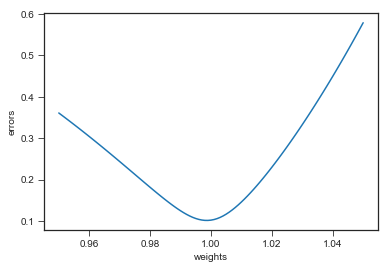

In [49]:
select_weights()

In [56]:
test['StateHoliday_b']=0
test['StateHoliday_c']=0

In [59]:
dtest=xgb.DMatrix(test[features])

In [60]:
params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.04,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 13   # Random number seed
          }
num_round = 2500

In [61]:
model = xgb.train(params, dtrain_total, num_round)
preds = model.predict(dtest)

In [62]:
preds

array([8.339878, 8.53783 , 9.155214, ..., 8.78739 , 8.083408, 8.869456],
      dtype=float32)

In [63]:
result= np.expm1(preds*0.999)

In [64]:
sub_df=pd.DataFrame({'Id':test.Id,'Sales':result})

In [65]:
sub_df.head()

,Id,Sales
0,1,4151.800293
563,564,5059.866699
565,566,9376.411133
566,567,6565.778809
567,568,14396.035156


In [66]:
sub_df.to_csv('sub_df15.csv',index=None)

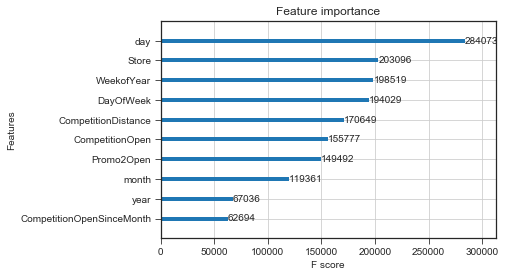

In [67]:
xgb.plot_importance(model,max_num_features= 10)